In [48]:
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets
from torchtext.vocab import Vectors, GloVe, CharNGram, FastText

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

import matplotlib.pyplot as plt


In [49]:
################################
# DataLoader
################################

# set up fields
TEXT = data.Field()
LABEL = data.Field(sequential=False,dtype=torch.long)

# make splits for data
# DO NOT MODIFY: fine_grained=True, train_subtrees=False
train, val, test = datasets.SST.splits(
    TEXT, LABEL, fine_grained=True, train_subtrees=False)

# print information about the data
print('train.fields', train.fields)
print('len(train)', len(train))
print('vars(train[0])', vars(train[0]))

# build the vocabulary
# you can use other pretrained vectors, refer to https://github.com/pytorch/text/blob/master/torchtext/vocab.py
TEXT.build_vocab(train, vectors=Vectors(name='vector.txt', cache='./data'))
LABEL.build_vocab(train)
# We can also see the vocabulary directly using either the stoi (string to int) or itos (int to string) method.
print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)
print(TEXT.vocab.freqs.most_common(20))

# print vocab information
print('len(TEXT.vocab)', len(TEXT.vocab))
print('TEXT.vocab.vectors.size()', TEXT.vocab.vectors.size())

# Copy the pre-trained word embeddings we loaded earlier into the embedding layer of our model.
pretrained_embeddings = TEXT.vocab.vectors


train.fields {'text': <torchtext.legacy.data.field.Field object at 0x7f5a1c3d7070>, 'label': <torchtext.legacy.data.field.Field object at 0x7f5a1c3d7f70>}
len(train) 8544
vars(train[0]) {'text': ['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], 'label': 'positive'}
['<unk>', '<pad>', '.', ',', 'the', 'and', 'a', 'of', 'to', "'s"]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f5a1c3d7fd0>>, {'<unk>': 0, 'positive': 1, 'negative': 2, 'neutral': 3, 'very positive': 4, 'very negative': 5})
[('.', 8024), (',', 7131), ('the', 6037), ('and', 4431), ('a', 4403), ('of', 4386), ('to', 2995), ("'s", 2544), ('is', 2536), ('that', 1915), ('in', 1789), ('it', 1775), ('The', 1265), ('as', 1200), ('film', 1152), (

In [62]:
################################
# Model
################################
class classifier(nn.Module):
 
    def __init__(self, hidden_size, num_layers, bidirectional, dropout):
        
        super(classifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.embedding.weight.requires_grad = False

        self.dropout = nn.Dropout(dropout)

        self.encoder = nn.LSTM(input_size=300, 
                           hidden_size=hidden_size, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional,
                           dropout=dropout)
        if bidirectional:
            self.fc = nn.Linear(hidden_size* 2, 5)
        else:
            self.fc = nn.Linear(hidden_size, 5)
    
    def forward(self, x):
        x_embedded = self.embedding(x)
        # x_embedded = self.dropout(x_embedded)
        output, (hidden, _) = self.encoder(x_embedded)
        output = output[0]
        output = self.fc(output)
        output = self.dropout(output)
        output = F.softmax(output, dim=1)

        return output

             

In [63]:
################################
# Training settings
################################

hidden_size = 128
num_layers = 2
bidirectional = True
dropout = 0.5

model = classifier(hidden_size=hidden_size, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout)
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
# multigpu
# device_ids = [0, 1]
# model = nn.DataParallel(model, device_ids=device_ids)

lr = 1.0    # Note the default learning rate for optimizer Adadelta is 1.0
epochs = 100
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)



classifier(
  (embedding): Embedding(18280, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (encoder): LSTM(300, 128, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)
cuda


In [64]:
################################
# Train and val.
################################

Train_loss, Train_acc, Val_loss, Val_acc = [], [], [], []

# make iterator for splits
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train, val, test), batch_size=batch_size, shuffle = True)

# # print batch information
# batch = next(iter(train_iter)) # for batch in train_iter
# print(batch.text) # input sequence
# print(batch.label) # groud truth

for epoch in range(epochs):
    Train_loss_epoch, Train_acc_epoch, Val_loss_epoch, Val_acc_epoch = 0, 0, 0, 0

    # train
    model.train()
    for batch in train_iter:
        optimizer.zero_grad()
        text, label = batch.text.to(device), (batch.label - 1).to(device)
        output = model(text)
        # print(output.shape)
        # print(label.shape)
        
        loss = criterion(output, label)
        acc = torch.sum(torch.argmax(output, 1) == label) / float(batch_size)
        loss.backward()
        optimizer.step()

        Train_loss_epoch += loss.item()
        Train_acc_epoch += acc.item()
    
    Train_loss.append(Train_loss_epoch / len(train_iter))
    Train_acc.append(Train_acc_epoch / len(train_iter))

    # val.
    with torch.no_grad():
        model.eval()
    for batch_v in val_iter:
        text_v, label_v = batch_v.text.to(device), (batch_v.label - 1).to(device)
        output_v = model(text_v)
        
        loss_v = criterion(output_v, label_v)
        acc_v = torch.sum(torch.argmax(output_v, 1) == label_v) / float(batch_size)

        Val_loss_epoch += loss_v.item()
        Val_acc_epoch += acc_v.item()
    
    Val_loss.append(Val_loss_epoch / len(val_iter))
    Val_acc.append(Val_acc_epoch / len(val_iter))

    scheduler.step()

    # print info.
    print("Epoch: {}/{}.. ".format(epoch+1, epochs),
            "Train_loss: {:.3f}.. ".format(Train_loss[epoch]),
            "Train_acc: {:.3f}.. ".format(Train_acc[epoch]),
            "Val_loss: {:.3f}.. ".format(Val_loss[epoch]),
            "Val_acc: {:.3f}".format(Val_acc[epoch]))

Epoch: 1/100..  Train_loss: 1.603..  Train_acc: 0.252..  Val_loss: 1.595..  Val_acc: 0.218
Epoch: 2/100..  Train_loss: 1.593..  Train_acc: 0.263..  Val_loss: 1.588..  Val_acc: 0.218
Epoch: 3/100..  Train_loss: 1.591..  Train_acc: 0.262..  Val_loss: 1.586..  Val_acc: 0.225
Epoch: 4/100..  Train_loss: 1.589..  Train_acc: 0.264..  Val_loss: 1.584..  Val_acc: 0.246
Epoch: 5/100..  Train_loss: 1.587..  Train_acc: 0.270..  Val_loss: 1.581..  Val_acc: 0.247
Epoch: 6/100..  Train_loss: 1.587..  Train_acc: 0.271..  Val_loss: 1.581..  Val_acc: 0.230
Epoch: 7/100..  Train_loss: 1.586..  Train_acc: 0.276..  Val_loss: 1.578..  Val_acc: 0.258
Epoch: 8/100..  Train_loss: 1.584..  Train_acc: 0.271..  Val_loss: 1.573..  Val_acc: 0.301
Epoch: 9/100..  Train_loss: 1.576..  Train_acc: 0.288..  Val_loss: 1.563..  Val_acc: 0.285
Epoch: 10/100..  Train_loss: 1.571..  Train_acc: 0.305..  Val_loss: 1.550..  Val_acc: 0.286
Epoch: 11/100..  Train_loss: 1.561..  Train_acc: 0.330..  Val_loss: 1.552..  Val_acc: 0.2

In [65]:
################################
# Save
################################
state = model.state_dict()
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.pth')

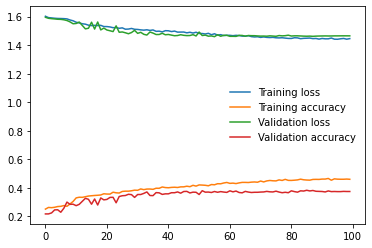

In [69]:
################################
# Plot the train result
################################
plt.plot(Train_loss, label='Training loss')
plt.plot(Train_acc, label='Training accuracy')
plt.plot(Val_loss, label='Validation loss')
plt.plot(Val_acc, label='Validation accuracy')
plt.legend(frameon=False)

In [72]:
################################
# Test
################################
Test_loss, Test_acc = 0, 0
with torch.no_grad():
    model.eval()
for batch_t in test_iter:
    text_t, label_t = batch_t.text.to(device), (batch_t.label - 1).to(device)
    output_t = model(text_t)
    loss_t = criterion(output_t, label_t)
    acc_t = torch.sum(torch.argmax(output_t, 1) == label_t) / float(batch_size)

    Test_loss += loss_t.item()
    Test_acc += acc_t.item()

print("Test Loss: {:.3f}\n".format(Test_loss / len(test_iter)),
        "Test Accuracy: {:.3f}".format(Test_acc / len(test_iter)))

Test Loss: 1.449
 Test Accuracy: 0.422
